## The notebook contains 3 main parts:

For some models, I simplly fitted the data and only look at the accuracy score. For three methods that are relatveily more complex: GridSearch CV + Pipeline, Stacking, and NN, I included more detailed evaluation.

### Model validation
- Cross validation (KFold)
- GridSearch CV 
- Pipeline
- GridSearch CV + Pipeline to fit 5 folds for each of 270 candidates, totalling 1350 fits (with detailed evaluation)
  
### Ensemble learning
- Boosting
- Stacking (with detailed evaluation)

### NN for a binary classification task (with detailed evaluation)

# Part I: Model validation


## Cross validation (KFold)

In [185]:
from sklearn import datasets
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from time import time

In [186]:
# load the dataset
df = pd.read_csv('C:/Users/Victoria/OneDrive/文档/Dropbox/Machine Learning Python/Project/data_EDA.csv') 
#generate next year GDP
df_aggregated = df.groupby('Year')['gdp'].mean().reset_index()
df_aggregated['next_year_gdp'] = df_aggregated['gdp'].shift(-1)

# Merge the lagged GDP data back to the original DataFrame
df = df.merge(df_aggregated[['Year', 'next_year_gdp']], on='Year', how='left')
df['next_year_gdp_grow_dummy'] = np.where(df['next_year_gdp'] > 0, 1, 0)


df.dropna(inplace=True)

In [187]:
X = df.drop(columns=['Year', 'gdp', 'Title', 'Description', 'gdp_normal',  'lag_gdp','gdp_grow_dummy','source',
                     'Tokenized_Description', 'Stem_Lemm_Description', 'Processed_Words', 'Joined_Words','next_year_gdp','next_year_gdp_grow_dummy'])  # Features
y = df['next_year_gdp_grow_dummy']  # Target variable
y = y.reset_index(drop=True) # Reset the index of y to make it align with integer locations
X = X.reset_index(drop=True) # Reset the index of y to make it align with integer locations

In [188]:
X.shape, y.shape

((5920, 30), (5920,))

- Tain/test split

In [189]:
from sklearn.model_selection import train_test_split

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state=42, shuffle=True)

In [191]:
X_train.shape, y_train.shape, Counter(y_train)
# 3552 samples, and each sample has 30 features. 
# Here, 1 represents the class where the GDP is predicted to grow the next year, and 0 represents the class where it is not.

((3552, 30), (3552,), Counter({1: 3186, 0: 366}))

In [192]:
X_test.shape, y_test.shape, Counter(y_test)

((2368, 30), (2368,), Counter({1: 2129, 0: 239}))

- Before doing K-folds, this fits a classifier on training data and test on testing data using a logistic regression model, which has achieved an accuracy score of approximately 0.902 on the test set. This means that the model correctly predicted whether the GDP would grow the next year or not for 90.2% of the cases in the test dataset.

In [193]:
from sklearn.linear_model import LogisticRegression

In [194]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9024493243243243

### Option-1: directly apply cross validation to get the model validation scores

I am using 10-fold cross-validation. In this method, the dataset is divided into 10 folds. During the cross-validation process, the model is trained 10 times, each time using 9 of the 10 folds for training and the remaining fold for testing. 

In reviewing the recall scores from the 10-fold cross-validation, I observed that 6 out of 10 folds yielded perfect scores of 1.0, indicating that my logistic regression model successfully identified all instances of next year's GDP growth binary variable without missing any in these folds. However, in the remaining folds, the scores were slightly lower. These scores suggest that while the model is generally reliable, there are instances where it fails to capture all positive cases, which may be due to variations in data characteristics or model sensitivity across different subsets of the dataset.

In [195]:
from sklearn.model_selection import cross_validate, cross_val_score

In [196]:
clf = LogisticRegression(random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=10, scoring='recall')

In [197]:
cv_scores

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99811676, 0.99811676, 0.92655367, 0.95291902])

### Option-2: apply KFold to split the data into K-folds and then do cross validation on the k-fold data

The scores are similar to the option above. The difference is due to the sequence of procedures in splitting data.   Since the original dataset appears to be significantly imbalanced towards class 1 (postive next year gdp groth, this inherent imbalance means any random or even somewhat stratified sampling without specific techniques to address imbalance will reflect this disparity, as indicated by the difference train labels count and 
Test labels cout for each folds.)

In [198]:
from sklearn.model_selection import KFold

In [199]:
# apply KFold split on the dataset
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(X):
    # Use iloc to access rows based on integer indices
    train_y = y.iloc[train_idx]
    test_y = y.iloc[test_idx]
    print("Train labels count:", Counter(train_y))
    print("Test labels count:", Counter(test_y))


Train labels count: Counter({1: 4777, 0: 551})
Test labels count: Counter({1: 538, 0: 54})
Train labels count: Counter({1: 4789, 0: 539})
Test labels count: Counter({1: 526, 0: 66})
Train labels count: Counter({1: 4778, 0: 550})
Test labels count: Counter({1: 537, 0: 55})
Train labels count: Counter({1: 4787, 0: 541})
Test labels count: Counter({1: 528, 0: 64})
Train labels count: Counter({1: 4795, 0: 533})
Test labels count: Counter({1: 520, 0: 72})
Train labels count: Counter({1: 4778, 0: 550})
Test labels count: Counter({1: 537, 0: 55})
Train labels count: Counter({1: 4780, 0: 548})
Test labels count: Counter({1: 535, 0: 57})
Train labels count: Counter({1: 4786, 0: 542})
Test labels count: Counter({1: 529, 0: 63})
Train labels count: Counter({1: 4784, 0: 544})
Test labels count: Counter({1: 531, 0: 61})
Train labels count: Counter({1: 4781, 0: 547})
Test labels count: Counter({1: 534, 0: 58})


In [200]:
Counter(y[train_idx]), Counter(y[test_idx])

(Counter({1: 4781, 0: 547}), Counter({1: 534, 0: 58}))

In [201]:
clf = LogisticRegression(random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='recall') 
cv_scores

array([1.        , 0.9904943 , 0.99627561, 1.        , 0.99230769,
       0.9981378 , 1.        , 0.99432892, 0.99811676, 0.98689139])

### Option-3: apply stratified KFold to keep the class distribution

In Stratified K-Fold, each fold is made by preserving the percentage of samples for each class. This means that each fold will have approximately the same percentage of samples of each class as the original dataset.

In [202]:
from sklearn.model_selection import StratifiedKFold

In [203]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(X,y):
    # Use iloc to access rows based on integer indices
    train_y = y.iloc[train_idx]
    test_y = y.iloc[test_idx]
    print("Train labels count:", Counter(train_y))
    print("Test labels count:", Counter(test_y))

Train labels count: Counter({1: 4783, 0: 545})
Test labels count: Counter({1: 532, 0: 60})
Train labels count: Counter({1: 4783, 0: 545})
Test labels count: Counter({1: 532, 0: 60})
Train labels count: Counter({1: 4783, 0: 545})
Test labels count: Counter({1: 532, 0: 60})
Train labels count: Counter({1: 4783, 0: 545})
Test labels count: Counter({1: 532, 0: 60})
Train labels count: Counter({1: 4783, 0: 545})
Test labels count: Counter({1: 532, 0: 60})
Train labels count: Counter({1: 4784, 0: 544})
Test labels count: Counter({1: 531, 0: 61})
Train labels count: Counter({1: 4784, 0: 544})
Test labels count: Counter({1: 531, 0: 61})
Train labels count: Counter({1: 4784, 0: 544})
Test labels count: Counter({1: 531, 0: 61})
Train labels count: Counter({1: 4784, 0: 544})
Test labels count: Counter({1: 531, 0: 61})
Train labels count: Counter({1: 4784, 0: 544})
Test labels count: Counter({1: 531, 0: 61})


In [204]:
clf = LogisticRegression(random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='recall') 
cv_scores

array([0.9981203 , 0.9943609 , 0.9981203 , 0.9924812 , 0.9962406 ,
       0.99811676, 0.99435028, 0.99623352, 0.99811676, 0.99623352])

#### Discussion:
Using cross-validation methods yields higher scores then simply applying logistic regression once.  Now that each fold serves as a test set at some point, and the rest of the data as training data, this reduces the variance in the estimated performance metrics and providing a more reliable measure of the model’s ability.

### Option-4: Leave One Out strategy, useful when don't have enough data

For this one, since my sample size is not very small. Calculating the score is time-consuming. So the score will not reported.

In [205]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

In [206]:
for train_idx, test_idx in loo.split(X):
    print("Train samples: %s \nTest samples: %s\n" % (train_idx, test_idx))
    break

Train samples: [   1    2    3 ... 5917 5918 5919] 
Test samples: [0]



clf = LogisticRegression(random_state=42)
scores = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Fit the model
    clf.fit(X_train, y_train)

    # Predict the test set
    y_pred = clf.predict(X_test)

    # Evaluate the prediction
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    # Optionally, break after the first to check the se*#up
    # break

# Calculate the mean accuracy across all LOO tests
mean_accuracy = np.mean(scores)
print("LOO CV Mean Accuracy:", mean_accuracy)

## GridSearchCV
- search for the best hyperparameter settings
- 'C':[0.1, 1, 10]: This is the inverse of regularization strength; smaller values specify stronger regularization. By adjusting C, I control the trade-off between achieving a lower-variance, higher-bias model with strong regularization (C is small), and a lower-bias, higher-variance model with weaker regularization (C is large). 
The values starsg from a relatively strong regularization (0.1) to a weaker one (10)
- solver: ['liblinear']
This specifies the algorithm to use in the optimization problem. liblinear is a good choice for small datasets and binary classification problem
- penalty: ['l1', 'l2'] (Lasso regularization) produce sparse models with fewer non-zero coefficients, effectively performing feature selection by driving some coefficient estimates to exactly zero. (Ridge regularization) shrinks the coefficients but never sets them to zero. It spreads the penalty across all coefficients, which helps to improve model robustness by avoiding the undue influence of any single feature.. .

In [207]:
from sklearn.model_selection import GridSearchCV

In [208]:
lr = LogisticRegression(penalty='l1',solver='liblinear',random_state=42,max_iter=2000)
lr.fit(X, y)

LogisticRegression(max_iter=2000, penalty='l1', random_state=42,
                   solver='liblinear')

In [209]:
lr = LogisticRegression(random_state=42)
parameters = {'penalty':('l1', 'l2'), 
              'C':[0.1, 1, 10],
              'solver': ['liblinear']} # 2*3*1 = 6 combinations of parameters

grid_cv = GridSearchCV(estimator = lr, param_grid = parameters, cv=5)

grid_cv.fit(X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'penalty': ('l1', 'l2'),
                         'solver': ['liblinear']})

In [210]:
sorted(grid_cv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_penalty',
 'param_solver',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [211]:
grid_cv.cv_results_['mean_fit_time']

array([0.01914692, 0.0217422 , 0.01835032, 0.01795235, 0.0167532 ,
       0.02293901])

In [212]:
grid_cv.cv_results_['mean_test_score']

array([0.87702703, 0.87381757, 0.86131757, 0.86131757, 0.85929054,
       0.85962838])

In [213]:
grid_cv.cv_results_['split0_test_score']

array([0.89780405, 0.89780405, 0.89780405, 0.89780405, 0.89780405,
       0.89780405])

In [214]:
grid_cv.best_estimator_ 

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

In [215]:
grid_cv.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [216]:
grid_cv.best_score_

0.8770270270270271

#### Discussion

##### Best Parameters

- **C: 0.1** — This value suggests that stronger regularization helps to prevent overfitting and improves the model's generalization capability on the dataset.

- **Penalty: 'l1'** — This makes sense since the dataset contains some features that are irrelevant for prediction. L1 regularization can reduce their coefficients to zero, effectively performing feature selection.

- **Solver: 'liblinear'** — This solver is suitable for binary classification problems and supports L1 regularization, which aligns with the finding#s.

#### Performance

- The best score of 0.877 (or 87.70%) is lower than the previous K-Folds validation scores. This discrepancy may be due to the parameters chosen during the GridSearchCV, particularly the L1 penalty and strong regularization, which emphasize model simplicity and generalization over fitting to potentially more complex patterns in the training data.
gs.


## Pipeline

In logistic regression, using StandardScaler helps in speeding up the convergence of the stochastic gradient descent algorithm used in the background and can also lead to a more stable model.
Accuracy of 90.33% suggests that the model performs well on this particular test set, accurately predicting the target variable most of the tim. But due to the imbalance nature, this score does not mean anything.e


In [217]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [218]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic', LogisticRegression())
])

In [219]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic', LogisticRegression())])

In [220]:
pipe.score(X_test, y_test)

0.903293918918919

## Hyper-parameter tunning using GridSearchCV and pipeline 
-  text classification
- jointly find the best hyperparameters in each step of the pipeline

In [221]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time

In [222]:
print(df.Description)

43            Climate change is above all an equity issue
44      Favourable terms of trade provide much needed ...
45      UN GA adopts resolution to graduate these thre...
46      Davos-style dialogue on the theme of the Confe...
47      To address the existing barriers to the adopti...
                              ...                        
6526    This Selected Issues paper discusses interacti...
6527    This Selected Issues paper summarizes achievem...
6528    This Selected Issues paper aims to take stock ...
6529    Economic developments over the past two years ...
6530    The U.S. is in the midst of an unprecedented s...
Name: Description, Length: 5920, dtype: object


In [223]:
df.iloc[4888]['Description']

'Uruguay has consolidated economic gains, supported by strong macroeconomic policies and a broadly favorable external environment. Growth has exceeded expectations, unemployment has reached record lows, and poverty has continued to fall, while economic vulnerabilities have been significantly reduced. Despite strong credit growth, financial system soundness indicators have improved, showing a well-capitalized banking system, low nonperforming loan ratios and high liquidity levels. Executive Directors have welcomed the measures the authorities have taken to reduce inflationary pressures, including increases in the policy rate and banks’ reserve requirements and tax administrative measures.'

### Define a pipeline: text feature extraction + classifier 

In [224]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

custom_stop_words = set(ENGLISH_STOP_WORDS).union({'gdp','2018','2019','2020','azevêdo','2021','roberto','conference','takes','september','countries','members','forum','programme','december','notified','organization','certain','ministerial','chf','china','basis','general','march','place','external','2022','2023','2017','2016','unit','2015','2014','2013','2012','2011','2010','2009','2008','2007','2006','2005','2004','2003','2002','2001','2000','highlight','includ','agreement','19','organ','financ','domest','trade','larg','structur','fund','pascal','lami','implement','committe','region','recent','medium','octob','work','ass','outlook','framework','gpd','project','polici','state','new','consult','financi','expect','negoti','develop','product','economi','wa','govern','world','bank','review','extern','intern','said','discus','ha','thi','wto','countri','percent','report','gener','growth','director','global','author','member','econom','articl','iv','measure','year','market','public','sector','measur','term','meet'})
custom_stop_words = list(custom_stop_words)

pipeline = Pipeline([
    ("vect", CountVectorizer(min_df=5, max_df=0.8, ngram_range=(1,1), binary=False, stop_words=custom_stop_words)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression())
])

In [225]:
pipeline.steps

[('vect',
  CountVectorizer(max_df=0.8, min_df=5,
                  stop_words=['once', 'structur', 'yet', 'roberto', 'own',
                              'bottom', 'hereafter', 'both', 'he', 'because',
                              'whenever', '2017', 'otherwise', 'whoever', '2012',
                              'serious', 'well', 'bill', 'empty', 'from',
                              'although', 'azevêdo', 'thus', 'unit', 'one',
                              'fill', 'along', 'chf', 're', 'perhaps', ...])),
 ('tfidf', TfidfTransformer()),
 ('clf', LogisticRegression())]

### Explore the parameters: search over different values

In [226]:
parameters = {
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [1, 2, 5],  
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_features': [None, 1000],  # None means no limit
    'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}


In [227]:
X_grid = df['Description']  # Features
y_grid = df['next_year_gdp_grow_dummy']  # Target variable
y_grid = y_grid.reset_index(drop=True) # Reset the index of y to make it align with integer locations
X_grid = X_grid.reset_index(drop=True) # Reset the index of y to make it align with integer locations

### Jointly find the best parameters for both feature extraction and the classifier

In [228]:
from pprint import pprint
from time import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1, error_score='raise')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X_grid,y_grid)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': [0.01, 0.1, 1.0, 10.0, 100.0],
 'vect__max_df': [0.5, 0.75, 1.0],
 'vect__max_features': [None, 1000],
 'vect__min_df': [1, 2, 5],
 'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]}
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
done in 378.584s

Best score: 0.898
Best parameters set:
	clf__C: 0.01
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 1
	vect__ngram_range: (1, 1)


In [229]:
# Access the best estimator from grid search
best_clf = grid_search.best_estimator_

# get the feature names
vect = best_clf.named_steps['vect'] 
feature_names = vect.get_feature_names_out()

# Access the logistic regression model
logistic_model = best_clf.named_steps['clf']  # Replace 'clf' with the name used for the logistic regression step in  pipeline

# Get the coefficients from the logistic regression model
coefficients = logistic_model.coef_[0]


# Create a DataFrame of features and their corresponding coefficients
feature_importance = pd.DataFrame({
    'features': feature_names,
    'coefficients': coefficients
})

# Sort the features by the absolute values of their coefficients
top_features = feature_importance.reindex(feature_importance.coefficients.abs().sort_values(ascending=False).index)

print("Top 5 Negative Features:")
# Display the top 5 features
print(top_features.head(5))

positive_features = feature_importance[feature_importance['coefficients'] > 0].sort_values(by='coefficients', ascending=False)

# Display the top 5 positive features
print("Top 5 Positive Features:")
print(positive_features.head(5))


Top 5 Negative Features:
         features  coefficients
4620       fiscal     -0.097391
4591    financial     -0.074971
8677      reforms     -0.068894
10053  structural     -0.060395
7967       policy     -0.052434
Top 5 Positive Features:
       features  coefficients
7640   pandemic      0.035109
8623   recovery      0.031989
2855      covid      0.028906
2892     crisis      0.028180
10911     union      0.027001


In [230]:
y_pred = best_clf.predict(X_grid)

# Calculate accuracy
accuracy = accuracy_score(y_grid, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
class_report = classification_report(y_grid, y_pred)
print("Classification Report:")
print(class_report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_grid, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8978040540540541
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       605
           1       0.90      1.00      0.95      5315

    accuracy                           0.90      5920
   macro avg       0.45      0.50      0.47      5920
weighted avg       0.81      0.90      0.85      5920

Confusion Matrix:
[[   0  605]
 [   0 5315]]


C:\Users\Victoria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Victoria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Victoria\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:

df['Predicted'] = y_pred  # model predictions
df['Actual'] = y_grid     # actual outcomes
df['Correct'] = df['Predicted'] == df['Actual']  # True if correct, False if incorrect

# Filter out incorrect predictions
errors = df[df['Correct'] == False]

# Calculate the count of errors per year
errors_per_year = errors['Year'].value_counts()

# Calculate the total number of predictions per year
total_predictions_per_year = df['Year'].value_counts()

# Calculate the percentage of false predictions per year
percentage_errors_per_year = (errors_per_year / total_predictions_per_year) * 100


In [232]:
# Sort the percentages in descending order
sorted_percentage_errors_per_year = percentage_errors_per_year.sort_values(ascending=False)

# Display the top 5 years with the highest error rates
top_5_years_errors = sorted_percentage_errors_per_year.head(5)
print("Top 5 Years with Highest Percentage of False Predictions:")
print(top_5_years_errors)


Top 5 Years with Highest Percentage of False Predictions:
Year
2020-01-01    74.688797
2021-01-01    62.758621
2019-01-01    49.537037
2007-01-01    38.700565
2015-01-01    16.051661
Name: count, dtype: float64


### Model Summary and Evaluation
- The optimal parameters identified include a regularization strength (clf__C) of 0.01, suggesting a higher degree of regularization helps prevent overfitting and enhances model generalization. For the vectorization process, a maximum document frequency (vect__max_df) of 0.5 efficiently filters out very common terms, while the minimum document frequency (vect__min_df) set to 1 and the absence of a maximum feature limit (vect__max_features: None) ensure that all potentially informative terms are considered. The choice of unigram tokens (vect__ngram_range: (1, 1)) confirms that single words provide sufficient predictive power in this context.riable on model decisions.

### Conclusion
- The model is highly effective for the positive class but fails entirely for the negative class. Adjustments are necessary to improve its predictive capabilities across b
- For Class 0 (negative gdp growth), the model missed all the correct prediction, as indicat4ed by 0 value of Precision, Recall, F1-Score.
- The years with the highest percentages of incorrect predictions were 2020, 2021, 2019, 2007, and 2015. In 2020, the model had the highest error rate, with approximately 74.69% of the predictions being incorrect. This could potentially be attributed to the global impact of the COVID-19 pandemic, which introduced unprecedented economic disruptions that were not typical of the patterns seen in the training data from previous years. The year 2007, which marked the onset of the global financial crisis, had an error rate of 38.70%, underscoring potential difficulties in predicting downturns that are abrupt and driven by complex financial factors.
- The model's coefficients reveal how specific terms influence its predictions. "Fiscal," "financial," "reforms," "structural," and "policy" have negative values, suggesting that discussions around these topics are associated with adverse outcomes, possibly reflecting concerns or challenges in these areas. Conversely, "pandemic," "recovery," "covid," "crisis," and "union" show positive effects, likely capturing effective responses and rebound after facing significant challenges. th classes, enhancing fairness and accuracy.
mplex models that might capture the class characteristics better.


# Ensemble learning
- Boosting
- Stacking

## Boosting

Different boosting methods yield different accuracy scores.

In [233]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [234]:
dt = DecisionTreeClassifier(max_depth=1, random_state=42)
dt_scores = cross_val_score(dt, X, y, cv=5)
dt_scores.mean()

0.8567567567567569

In [235]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Mimicking AdaBoost with Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0)
rf_scores = cross_val_score(rf_clf, X, y, cv=5)
rf_mean = rf_scores.mean()

print("Average score of the mimicked Random Forest:", rf_mean)

Average score of the mimicked Random Forest: 0.8978040540540541


In [236]:
# create a boosting classifier
# please check documentation to understand what does "estimator=None" mean?
clf = AdaBoostClassifier(estimator=None, n_estimators=100, algorithm="SAMME")

In [237]:
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.8594594594594595

## Multi-layer stacking

In [238]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
final_layer_rfr = RandomForestRegressor(n_estimators=10, max_features=1, max_leaf_nodes=5,random_state=42)
final_layer_gbr = GradientBoostingRegressor(n_estimators=10, max_features=1, max_leaf_nodes=5,random_state=42)
final_layer = StackingRegressor(estimators=[('rf', final_layer_rfr),('gbrt', final_layer_gbr)],
                                final_estimator=RidgeCV())

multi_layer_regressor = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                      ('lasso', LassoCV(random_state=42)),
                                                      ('knr', KNeighborsRegressor(n_neighbors=20,metric='euclidean'))],
                                          final_estimator=final_layer)

multi_layer_regressor.fit(X_train, y_train)
multi_layer_regressor.score(X_test, y_test)

0.06840363946374095

In [239]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


threshold = 0.5

# Predict on the test set
y_pred_continuous = multi_layer_regressor.predict(X_test)

# Convert predictions to binary based on the threshold
y_pred_binary = np.where(y_pred_continuous >= threshold, 1, 0)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report for precision, recall, f1-score, and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_binary)
print("ROC AUC Score:", roc_auc)




Confusion Matrix:
[[   6  233]
 [   4 2125]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.03      0.05       239
           1       0.90      1.00      0.95      2129

    accuracy                           0.90      2368
   macro avg       0.75      0.51      0.50      2368
weighted avg       0.87      0.90      0.86      2368

ROC AUC Score: 0.511612893082379


## Model Performance Evaluation

- **True Positives (TP)** forpositive next year gdp growth1: 2125
- **True Negatives (TN)** fonegative next year gdp growth 0:, which is better than the previous model (with value 0). 6
- **False Positives (FP)**: 23 negative next year gdp growths 0 incorrectly classified  positive next year gdp growths 1)
- **False Negatives (FN)**:positive next year gdp growthss 1 incorrectly classifie  negative next year gdp growthss 0)

### Classification Report

- **Precision for Class 0**: 0.60
  - Indicates that 60% of the model's predic negative next year gdp growth  class 0 wer, a large improvement from before. correct.
- **Recall for Class 0**: 0.03
  - Only 3% of the actual class 0 instances were correctl, a small improvement from before.this class.
- **F1-Score for Class 0**: 0.05
  - The low F1-score for class 0 indicates poor balance between precision and recall, reflecting overall poor performance fo But it is a small improvement from before.r is the majority class.

### ROC AUC Score

- **ROC AUC Score**: 0.5116
  - The ROC AUC score close to 0.5 suggests that the model has no discriminative ability to distinguish between class 0 and class 1, eq But this is better than previous model, which is equal to 0.5uedictive accuracy across both classes.




### NN for a binary classification task

Here, I define a neural network (clf_model) using Keras' Sequential model, which allows me to build a model layer by layer. I add a dense (fully connected) layer with 7 neurons, using ReLU (Rectified Linear Unit) as the activation function(ReLU introduces non-linearity to the model, which is crucial because it allows the network to learn more complex patterns). The input shape is set to (30,), indicating that the model expects each input sample to be a 30-dimensional vector. The second dense layer is the output layer with 1 neuron, using a sigmoid(Sigmoid function outputs a value between 0 and 1, which makes it a natural choice for models where I need to predict the probability of an input being classified as one of two classes (0 or 1)) activation function. This setup is typical for binary classification, where the output is the probability of the sample belonging to one of the classes.

dense_6 (Dense): The first dense layer with 7 neurons. The output shape (None, 7) implies that the layer outputs a 7-dimensional vector per sample. The batch size is unspecified (hence None), meaning it can vary. Param # indicates the number of parameters in this layer, calculated as (input_features * neurons + bias_units) = (30 * 7 + 7) = 217.

dense_7 (Dense): The output layer with 1 neuron, resulting in a shape of (None, 1). This layer has 8 parameters, calculated from (neurons_in_previous_layer * neurons_in_this_layer + bias_units) = (7 * 1 + 1) = 8.

In [240]:
dataset = df.values

In [241]:
import numpy as np
import pandas as pd

import keras
from keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [242]:
# prepare data for model training
X = X
Y = y
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# split data into train/test/validation
X_data, X_test, y_data, y_test = train_test_split(X, encoded_Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, X_val.shape

((3788, 30), (1184, 30), (948, 30))

In [243]:
# Define a NN
clf_model = Sequential()
clf_model.add(Dense(7, input_shape=(30,), activation='relu'))
clf_model.add(Dense(1, activation='sigmoid'))

C:\Users\Victoria\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [244]:
clf_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 7)                   │             217 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

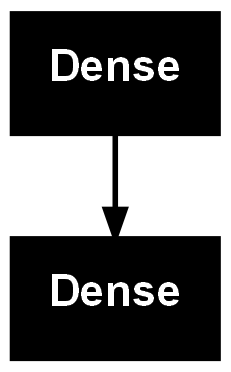

In [245]:
keras.utils.plot_model(clf_model, "binary_classifier.png") # show_shapes=True

In [246]:
clf_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [247]:
history = clf_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val,y_val))

Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6560 - loss: 0.6761 - val_accuracy: 0.8977 - val_loss: 0.5504
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8955 - loss: 0.5393 - val_accuracy: 0.9030 - val_loss: 0.4445
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8893 - loss: 0.4516 - val_accuracy: 0.9030 - val_loss: 0.3862
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9003 - loss: 0.3831 - val_accuracy: 0.9030 - val_loss: 0.3527
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8982 - loss: 0.3561 - val_accuracy: 0.9030 - val_loss: 0.3318
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8963 - loss: 0.3348 - val_accuracy: 0.9030 - val_loss: 0.3202
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8891 - loss: 0.3314 - val_accuracy: 0.9019 - val_loss: 0.3132
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8995 - loss: 0.3028 - val_accu

In [248]:
def visualize_performance(flag):
    history_dict = history.history
    epochs = range(1, len(history_dict["loss"]) + 1)

    plt.plot(epochs, history_dict[flag], "bo", label="Training "+flag)
    plt.plot(epochs, history_dict["val_"+flag], "b", label="Validation "+flag)
    plt.title("Training and validation "+flag)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

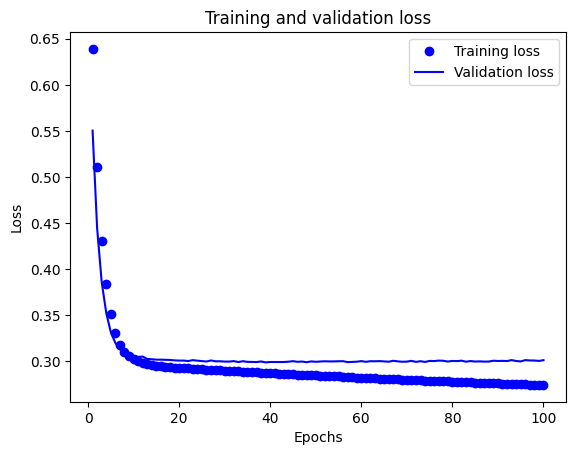

In [249]:
visualize_performance(flag = "loss")

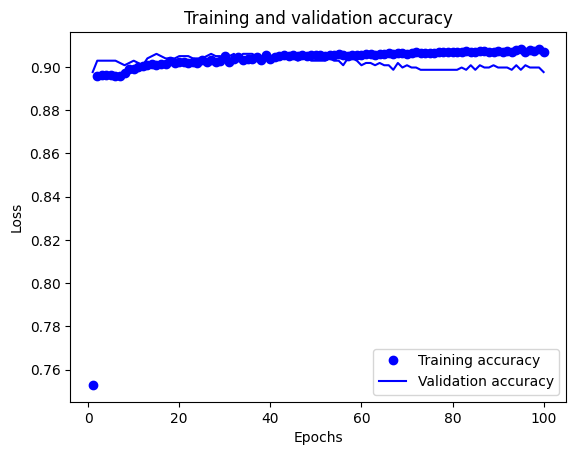

In [250]:
visualize_performance(flag = "accuracy")

In [251]:
# evaluate model performance regarding accuracy
test_loss, test_acc = clf_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9000 - loss: 0.3052 
test_acc: 0.895


In [252]:
# inference
y_pred_prob = clf_model.predict(X_test)
y_pred_labels = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred_labels))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
              precision    recall  f1-score   support

           0       0.44      0.12      0.19       120
           1       0.91      0.98      0.94      1064

    accuracy                           0.90      1184
   macro avg       0.67      0.55      0.57      1184
weighted avg       0.86      0.90      0.87      1184



In [253]:
conf_mat = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[  15  105]
 [  19 1045]]


In [254]:
roc_auc = roc_auc_score(y_test, y_pred_labels)
roc_auc

0.5535714285714286

### Evaluation:

#### Interpretation of Training and Validation Loss Graph
At the beginning, both training and validation losses decrease sharply. This indicates that the model is quickly learning from the training data. The rapid improvement suggests that the initial weights were quite far from the optimal, and early adjustments during training significantly improve the model's performance. After the initial sharp decrease, both the training and validation losses begin to stabilize. This stabilization suggests that the model is reaching a point where further learning on the training set does not significantly decrease the error on the validation set. The closeness of the training and validation loss throughout the training process suggests good generalization. There isn't a significant gap between the two, which often indicates that the model is not overfitting.

####  Training and Validation Accuracy Interpretation
Initially, there is a sharp increase in both training and validation accuracy. The training accuracy quickly reaches a high level and remains stable for the remainder of the training process.  The relatively small gap between training and validation accuracy through most of the epochs indicates good model generalization. The relatively small gap between training and validation accuracy through most of the epochs indicates good model generalization. There is no significant divergence that might suggest overfitting.

The accuracies stabilize after around 20 epochs, with little to no improvement in validation accuracy. This suggests that subsequent training does little to enhance the model’s ability to perform on unseen data, which might be an indicator to employ early stopping in future training sessions to save computational resources and prevent potential overfitting.

#### F1, Recall, ROC AUC
The updated evaluation metrics indicate an improvement in model performance to correctly classify the (class 0). The model shows only a modest improvement in F1 and a slight increase in recall, achieving a F1 of 0.19 and a recall of 0.12. The ROC AUC score of 0.55 shows only a slight improvement from random guessing.

In [255]:


# Function to calculate permutation feature importance for a DataFrame
def permutation_importance(model, X_val, y_val, metric=accuracy_score):
    baseline_score = metric(y_val, model.predict(X_val) > 0.5)
    importances = []
    
    # Convert DataFrame to numpy array for processing if not already
    X_val_np = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
    
    for i in range(X_val_np.shape[1]):
        save = X_val_np[:, i].copy()
        np.random.shuffle(X_val_np[:, i])
        shuffled_score = metric(y_val, model.predict(X_val_np) > 0.5)
        X_val_np[:, i] = save
        importances.append(baseline_score - shuffled_score)
    
    return np.array(importances)

# Calculate importances
feature_importances = permutation_importance(clf_model, X_val, y_val)
top_ten_features = np.argsort(feature_importances)[::-1][:10]


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
30/30 ━━━━━━━━━━━━━━━━━━━

In [256]:

feature_names = X.columns[top_ten_features]
print("Top 10 Features by Importance:")
print(feature_names)


Top 10 Features by Importance:
Index(['crisi', 'pandem', 'invest', 'recoveri', 'need', 'disput', 'challeng',
       'sustain', 'strengthen', 'import'],
      dtype='object')


The top ten features by importance in the model encompass a mix of economic, political, and social indicators that reflect key drivers of outcomes in various contexts. Features like "strengthen," "invest," and "import" highlight a focus on growth and trade activity, while terms like "pandemic" and "crisis" underscore the model’s sensitivity to emergency or exceptional conditions. "challeng" and "need" suggest attention to policy changes and potential hazards. The presence of "recoveri" indicates economic health recovery. Overall, these features illustrate the model's capability to incorporate critical and timely data, informing decisions across multiple domains effectively.



